In [1]:
import geopandas as gpd
import numpy as np
import os
from shapely.geometry import Point, Polygon
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import random

In [2]:
# Define path
path = os.getcwd()

# Import dataset
path = path + "\\provinces_area.shp"
gdf = gpd.read_file(path)
gdf_correct_province = gdf[gdf['Name']=="An Giang"]
gdf_correct_province

,Code,Name,area,perimeter,area [ha],geometry
0,AD01,An Giang,3.684739e+09,322721.990577,368474,"POLYGON ((105.11524 10.95566, 105.11463 10.946..."


In [3]:
polygon = gdf_correct_province.unary_union

C:\Users\sjuul\AppData\Local\Temp\ipykernel_29968\1511120387.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_correct_province.unary_union


In [9]:
s = gpd.GeoSeries(polygon)
points = s.sample_points(size=1000)

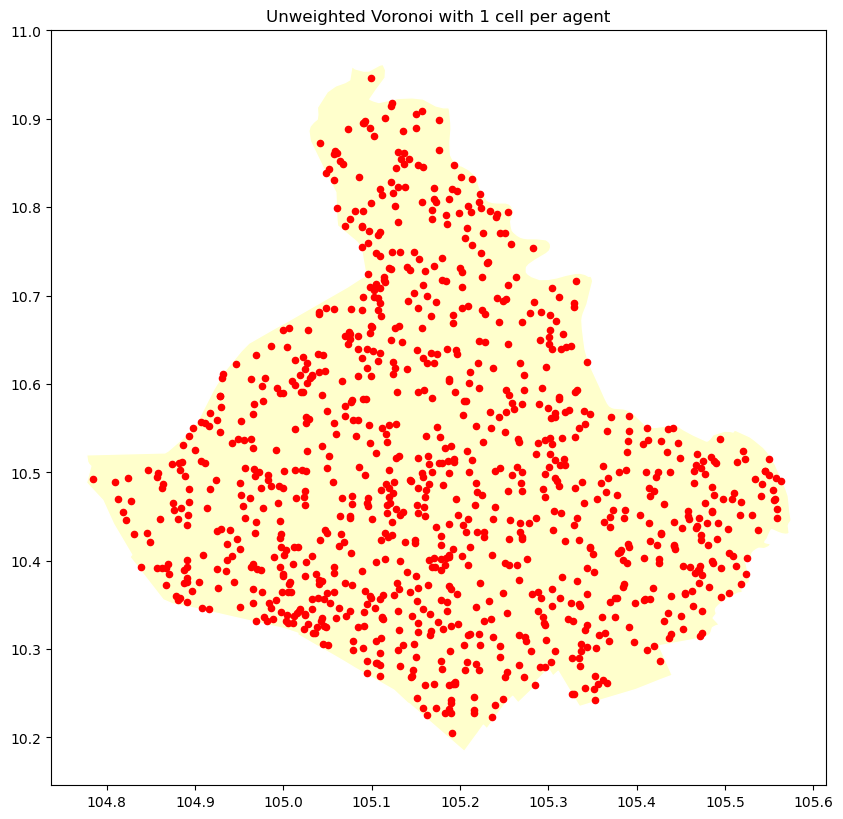

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_correct_province.plot(ax=ax, cmap="YlOrRd", edgecolor='white', legend=True)
points.plot(ax=ax, color='red', markersize=20)
plt.title("Unweighted Voronoi with 1 cell per agent")
plt.show()

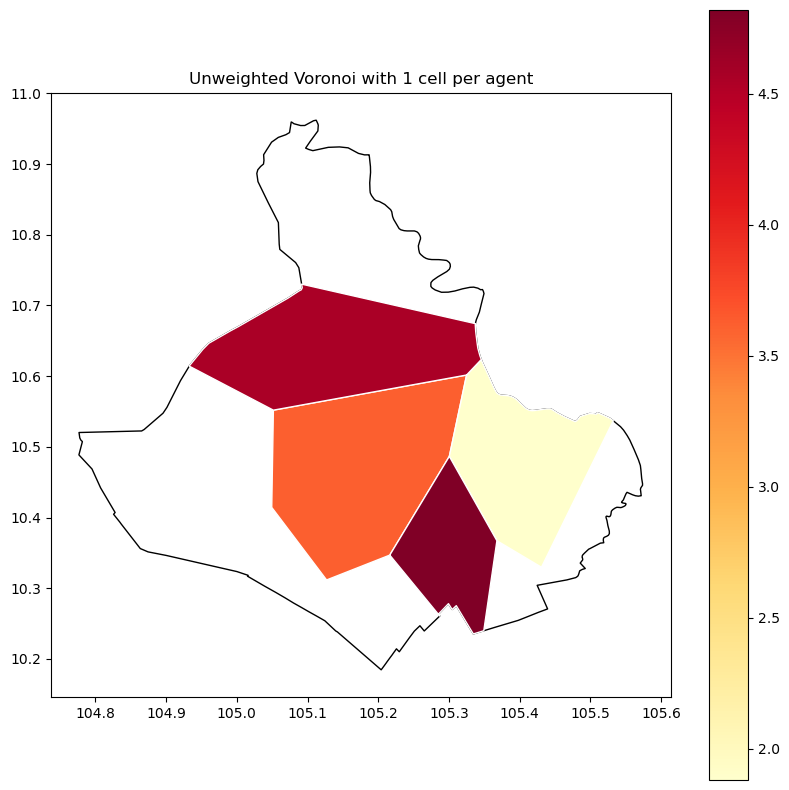

In [6]:
# Maak 10 agents met land_size
agents = []
num_agents = 10
for i in range(num_agents):
    land_size = random.uniform(1, 5)
    agents.append({
        "id": i,
        "land_size": land_size
    })

# Genereer 1 random punt per agent
minx, miny, maxx, maxy = polygon.bounds
agent_points = []
for agent in agents:
    while True:
        x, y = np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)
        p = Point(x, y)
        if polygon.contains(p):
            agent["point"] = p
            agent_points.append([x, y])
            break

# Voronoi
vor = Voronoi(agent_points)

# Maak Voronoi polygons
def voronoi_polygons(vor, boundary):
    regions = []
    for region_idx in vor.point_region:
        indices = vor.regions[region_idx]
        if not indices or -1 in indices:
            continue
        poly = Polygon([vor.vertices[i] for i in indices])
        poly = poly.intersection(boundary)
        if poly.is_valid and not poly.is_empty:
            regions.append(poly)
    return regions

voronoi_cells = voronoi_polygons(vor, polygon)

# Combineer met agent info
agent_polys = []
for i, cell in enumerate(voronoi_cells):
    agent_polys.append({
        "id": agents[i]["id"],
        "land_size": agents[i]["land_size"],
        "geometry": cell
    })

gdf_agents = gpd.GeoDataFrame(agent_polys)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_correct_province.plot(ax=ax, facecolor='none', edgecolor='black')
gdf_agents.plot(ax=ax, column="land_size", cmap="YlOrRd", edgecolor='white', legend=True)
plt.title("Unweighted Voronoi with 1 cell per agent")
plt.show()
